In [132]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon

# Create Training and Test Sets

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-50 ms",   "51-100 ms", "101-150 ms", "151-200 ms", "201-250 ms",
         "251-300 ms", "301-350 ms", "351-400 ms", "401-450 ms", "451-500 ms", 
         "501-550 ms", "551-600 ms", "601-650 ms", "651-700 ms", "701-750 ms", 
         "751-800 ms", "801-850 ms", "851-900 ms", "901-950 ms", "951-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-50 ms': 0,
 '51-100 ms': 1,
 '101-150 ms': 2,
 '151-200 ms': 3,
 '201-250 ms': 4,
 '251-300 ms': 5,
 '301-350 ms': 6,
 '351-400 ms': 7,
 '401-450 ms': 8,
 '451-500 ms': 9,
 '501-550 ms': 10,
 '551-600 ms': 11,
 '601-650 ms': 12,
 '651-700 ms': 13,
 '701-750 ms': 14,
 '751-800 ms': 15,
 '801-850 ms': 16,
 '851-900 ms': 17,
 '901-950 ms': 18,
 '951-1000 ms': 19}

### Load real edited videos
Define classes and preview

In [172]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


(504,
 504,
 Counter({3: 50,
          4: 50,
          6: 48,
          1: 54,
          5: 51,
          8: 52,
          2: 49,
          9: 52,
          0: 48,
          7: 50}))

### Load synthetically created feature points
Define classes and preview

In [716]:
# define synthetic data directory
output_dir = 'synthetic_data/output'
output_list = os.listdir(output_dir)

X_paths = [] # paths of segment folders
y = [] # designated label

for output_folder in output_list:
    if output_folder.startswith('vid'):
        x_path = output_dir + '/' + output_folder
        X_paths.append(x_path)
        
        # Extract class label from folder name
        params = re.findall(r'\d+', output_folder)
        label = int(int(params[3]) / 200)
        y.append(label)
        
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        # extract features
        X_pts = data['subset_all'].reshape(data['subset_all'].shape[0],60)
        X_feat = data['candidate_all']
        for frame in range(X_pts.shape[0]):
            X_occluded = np.where(X_pts[frame] == -1)
            X_feat[frame][X_pts[frame] == -1, :] = -1
        # only use body markers 0-17
        non_markers = [18,19,38,39,58,59]
        X_feat = X_feat[:20,:,0:2] # use 50 frames # try reshaping into 3 channels
        X_feat[:,0:17,0] -= np.mean(X_feat[:,0:17,0])
        X_feat[:,0:17,0] /= np.std(X_feat[:,0:17,0])
        X_feat[:,20:37,0] -= np.mean(X_feat[:,20:37,0])
        X_feat[:,20:37,0] /= np.std(X_feat[:,20:37,0])
        X_feat[:,40:57,0] -= np.mean(X_feat[:,40:57,0])
        X_feat[:,40:57,0] /= np.std(X_feat[:,40:57,0])
        X_feat[:,0:17,1] -= np.mean(X_feat[:,0:17,1])
        X_feat[:,0:17,1] /= np.std(X_feat[:,0:17,1])
        X_feat[:,20:37,1] -= np.mean(X_feat[:,20:37,1])
        X_feat[:,20:37,1] /= np.std(X_feat[:,20:37,1])
        X_feat[:,40:57,1] -= np.mean(X_feat[:,40:57,1])
        X_feat[:,40:57,1] /= np.std(X_feat[:,40:57,1])
        X_feat = np.squeeze(np.delete(X_feat, non_markers, axis=1).reshape(20,-1))
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
    
# Display video count and classes
len(X_paths), len(y), Counter(y)

(854, 854, Counter({0: 128, 4: 170, 2: 172, 5: 43, 3: 169, 1: 172}))

# Create Pytorch Dataset
## Load data
Split into training and test (apply transform if applicable)

In [173]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [194]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=0)
        sub2 = normalize(sample[:,56:112], axis=0)
        sub3 = normalize(sample[:,112:168], axis=0)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample

In [195]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_per_keypt(),
    transforms.ToTensor()
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

In [176]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [177]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [178]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [179]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168 #108 #168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size) # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |   CE: 8.3   |      7.8    |     7.8   |

In [186]:
# RNN Model Parameter
model_params = {
    "num_classes": 10,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cpu


SyncRNN(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
)

In [187]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x)
    print(y.shape) # should be [1,20]

torch.Size([1, 1, 10])


In [188]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")
#loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.1) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 200,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_leon.pt",
}

In [192]:
reload(trainutils_leon)
trained_model, loss_hist, metric_hist = trainutils_leon.train_model(model, train_params)

Epoch 0/199, current_lr=3



Saved best model weights
Train Loss: 79.378039, Dev Loss: 77.448326, Accuracy: 9.80
----------
Epoch 1/199, current_lr=3



Saved best model weights
Train Loss: 73.677473, Dev Loss: 69.112573, Accuracy: 9.80
----------
Epoch 2/199, current_lr=3



Train Loss: 84.673374, Dev Loss: 125.791887, Accuracy: 9.80
----------
Epoch 3/199, current_lr=3



Train Loss: 90.021977, Dev Loss: 88.303242, Accuracy: 9.80
----------
Epoch 4/199, current_lr=3



Train Loss: 69.453744, Dev Loss: 104.143358, Accuracy: 9.80
----------
Epoch 5/199, current_lr=3



Train Loss: 88.273421, Dev Loss: 103.046439, Accuracy: 9.80
----------
Epoch 6/199, current_lr=3



Train Loss: 76.119764, Dev Loss: 115.070107, Accuracy: 9.80
----------
Epoch 7/199, current_lr=3



Saved best model weights
Train Loss: 65.467538, Dev Loss: 45.774886, Accuracy: 9.80
----------
Epoch 8/199, current_lr=3



Train Loss: 77.931901, Dev Loss: 97.925580, Accuracy: 9.80
----------
Epoch 9/199, current_lr=3



Train Loss: 98.245699, Dev Loss: 99.028158, Accuracy: 9.80
----------
Epoch 10/199, current_lr=3



Train Loss: 73.990436, Dev Loss: 73.072079, Accuracy: 9.80
----------
Epoch 11/199, current_lr=3



Train Loss: 69.808824, Dev Loss: 70.897535, Accuracy: 11.76
----------
Epoch 12/199, current_lr=3



Saved best model weights
Train Loss: 65.419822, Dev Loss: 44.646173, Accuracy: 9.80
----------
Epoch 13/199, current_lr=3



Train Loss: 57.370739, Dev Loss: 78.154261, Accuracy: 9.80
----------
Epoch 14/199, current_lr=3



Train Loss: 102.268178, Dev Loss: 98.004299, Accuracy: 9.80
----------
Epoch 15/199, current_lr=3



Train Loss: 73.518205, Dev Loss: 66.469774, Accuracy: 9.80
----------
Epoch 16/199, current_lr=3



Train Loss: 68.643090, Dev Loss: 94.203676, Accuracy: 9.80
----------
Epoch 17/199, current_lr=3



Train Loss: 60.997238, Dev Loss: 90.545659, Accuracy: 9.80
----------
Epoch 18/199, current_lr=3



Epoch    24: reducing learning rate of group 0 to 2.1000e+00.
Loading best model weights
Train Loss: 54.094396, Dev Loss: 83.729574, Accuracy: 9.80
----------
Epoch 19/199, current_lr=2.0999999999999996



Train Loss: 53.890303, Dev Loss: 69.461809, Accuracy: 9.80
----------
Epoch 20/199, current_lr=2.0999999999999996



Train Loss: 66.660246, Dev Loss: 61.184008, Accuracy: 9.80
----------
Epoch 21/199, current_lr=2.0999999999999996



Saved best model weights
Train Loss: 53.174403, Dev Loss: 38.739550, Accuracy: 9.80
----------
Epoch 22/199, current_lr=2.0999999999999996



Train Loss: 50.024003, Dev Loss: 52.443005, Accuracy: 9.80
----------
Epoch 23/199, current_lr=2.0999999999999996



Train Loss: 54.576634, Dev Loss: 66.241876, Accuracy: 9.80
----------
Epoch 24/199, current_lr=2.0999999999999996



Train Loss: 56.385071, Dev Loss: 38.825877, Accuracy: 9.80
----------
Epoch 25/199, current_lr=2.0999999999999996



Train Loss: 44.702461, Dev Loss: 61.635247, Accuracy: 9.80
----------
Epoch 26/199, current_lr=2.0999999999999996



Train Loss: 48.634683, Dev Loss: 73.387150, Accuracy: 9.80
----------
Epoch 27/199, current_lr=2.0999999999999996



Epoch    33: reducing learning rate of group 0 to 1.4700e+00.
Loading best model weights
Train Loss: 52.273049, Dev Loss: 47.593132, Accuracy: 11.76
----------
Epoch 28/199, current_lr=1.4699999999999998



Train Loss: 43.232971, Dev Loss: 45.152185, Accuracy: 9.80
----------
Epoch 29/199, current_lr=1.4699999999999998



Saved best model weights
Train Loss: 36.677541, Dev Loss: 35.130283, Accuracy: 9.80
----------
Epoch 30/199, current_lr=1.4699999999999998



Train Loss: 32.179958, Dev Loss: 50.975988, Accuracy: 9.80
----------
Epoch 31/199, current_lr=1.4699999999999998



Train Loss: 53.357781, Dev Loss: 46.388854, Accuracy: 9.80
----------
Epoch 32/199, current_lr=1.4699999999999998



Train Loss: 32.880905, Dev Loss: 50.111625, Accuracy: 9.80
----------
Epoch 33/199, current_lr=1.4699999999999998



Saved best model weights
Train Loss: 33.507214, Dev Loss: 26.625647, Accuracy: 11.76
----------
Epoch 34/199, current_lr=1.4699999999999998



Saved best model weights
Train Loss: 32.696658, Dev Loss: 24.405683, Accuracy: 9.80
----------
Epoch 35/199, current_lr=1.4699999999999998



Train Loss: 30.767897, Dev Loss: 27.573466, Accuracy: 9.80
----------
Epoch 36/199, current_lr=1.4699999999999998



Train Loss: 38.805518, Dev Loss: 39.800009, Accuracy: 9.80
----------
Epoch 37/199, current_lr=1.4699999999999998



Train Loss: 41.969808, Dev Loss: 49.688974, Accuracy: 9.80
----------
Epoch 38/199, current_lr=1.4699999999999998



Train Loss: 37.919431, Dev Loss: 41.518364, Accuracy: 9.80
----------
Epoch 39/199, current_lr=1.4699999999999998



Train Loss: 47.179741, Dev Loss: 57.039565, Accuracy: 11.76
----------
Epoch 40/199, current_lr=1.4699999999999998



Epoch    46: reducing learning rate of group 0 to 1.0290e+00.
Loading best model weights
Train Loss: 44.647916, Dev Loss: 52.271781, Accuracy: 9.80
----------
Epoch 41/199, current_lr=1.0289999999999997



Train Loss: 25.956717, Dev Loss: 34.715887, Accuracy: 9.80
----------
Epoch 42/199, current_lr=1.0289999999999997



Train Loss: 25.107431, Dev Loss: 25.498398, Accuracy: 9.80
----------
Epoch 43/199, current_lr=1.0289999999999997



Saved best model weights
Train Loss: 24.584609, Dev Loss: 22.716006, Accuracy: 9.80
----------
Epoch 44/199, current_lr=1.0289999999999997



Saved best model weights
Train Loss: 19.948234, Dev Loss: 16.234271, Accuracy: 9.80
----------
Epoch 45/199, current_lr=1.0289999999999997



Saved best model weights
Train Loss: 14.148993, Dev Loss: 13.037561, Accuracy: 9.80
----------
Epoch 46/199, current_lr=1.0289999999999997



Train Loss: 14.611357, Dev Loss: 21.812055, Accuracy: 9.80
----------
Epoch 47/199, current_lr=1.0289999999999997



Train Loss: 22.995880, Dev Loss: 30.260482, Accuracy: 11.76
----------
Epoch 48/199, current_lr=1.0289999999999997



Train Loss: 21.326248, Dev Loss: 21.938098, Accuracy: 9.80
----------
Epoch 49/199, current_lr=1.0289999999999997



Train Loss: 19.790333, Dev Loss: 30.310606, Accuracy: 9.80
----------
Epoch 50/199, current_lr=1.0289999999999997



Train Loss: 20.235222, Dev Loss: 31.088810, Accuracy: 9.80
----------
Epoch 51/199, current_lr=1.0289999999999997



Epoch    57: reducing learning rate of group 0 to 7.2030e-01.
Loading best model weights
Train Loss: 23.010366, Dev Loss: 21.471029, Accuracy: 9.80
----------
Epoch 52/199, current_lr=0.7202999999999997



Train Loss: 11.878166, Dev Loss: 13.186422, Accuracy: 9.80
----------
Epoch 53/199, current_lr=0.7202999999999997



Train Loss: 10.336892, Dev Loss: 13.620363, Accuracy: 9.80
----------
Epoch 54/199, current_lr=0.7202999999999997



Saved best model weights
Train Loss: 10.153084, Dev Loss: 10.113789, Accuracy: 9.80
----------
Epoch 55/199, current_lr=0.7202999999999997



Train Loss: 12.452189, Dev Loss: 15.418615, Accuracy: 9.80
----------
Epoch 56/199, current_lr=0.7202999999999997



Saved best model weights
Train Loss: 13.418859, Dev Loss: 9.636431, Accuracy: 9.80
----------
Epoch 57/199, current_lr=0.7202999999999997



Train Loss: 11.968922, Dev Loss: 19.047874, Accuracy: 9.80
----------
Epoch 58/199, current_lr=0.7202999999999997



Train Loss: 14.750948, Dev Loss: 19.510132, Accuracy: 9.80
----------
Epoch 59/199, current_lr=0.7202999999999997



Train Loss: 14.821771, Dev Loss: 13.293521, Accuracy: 9.80
----------
Epoch 60/199, current_lr=0.7202999999999997



Train Loss: 12.410004, Dev Loss: 14.747534, Accuracy: 9.80
----------
Epoch 61/199, current_lr=0.7202999999999997



Saved best model weights
Train Loss: 13.038261, Dev Loss: 5.603827, Accuracy: 9.80
----------
Epoch 62/199, current_lr=0.7202999999999997



Train Loss: 9.257501, Dev Loss: 12.804838, Accuracy: 9.80
----------
Epoch 63/199, current_lr=0.7202999999999997



Saved best model weights
Train Loss: 7.498410, Dev Loss: 4.920565, Accuracy: 9.80
----------
Epoch 64/199, current_lr=0.7202999999999997



Train Loss: 7.642003, Dev Loss: 5.988910, Accuracy: 9.80
----------
Epoch 65/199, current_lr=0.7202999999999997



Train Loss: 5.603371, Dev Loss: 9.068290, Accuracy: 9.80
----------
Epoch 66/199, current_lr=0.7202999999999997



Train Loss: 8.688270, Dev Loss: 17.731034, Accuracy: 9.80
----------
Epoch 67/199, current_lr=0.7202999999999997



Train Loss: 13.614876, Dev Loss: 9.343425, Accuracy: 9.80
----------
Epoch 68/199, current_lr=0.7202999999999997



Train Loss: 8.876838, Dev Loss: 6.089938, Accuracy: 9.80
----------
Epoch 69/199, current_lr=0.7202999999999997



Epoch    75: reducing learning rate of group 0 to 5.0421e-01.
Loading best model weights
Train Loss: 7.078295, Dev Loss: 10.096176, Accuracy: 9.80
----------
Epoch 70/199, current_lr=0.5042099999999998



Train Loss: 5.605043, Dev Loss: 7.714415, Accuracy: 9.80
----------
Epoch 71/199, current_lr=0.5042099999999998



Saved best model weights
Train Loss: 4.777535, Dev Loss: 4.201921, Accuracy: 11.76
----------
Epoch 72/199, current_lr=0.5042099999999998



Train Loss: 4.677107, Dev Loss: 4.688511, Accuracy: 9.80
----------
Epoch 73/199, current_lr=0.5042099999999998



Saved best model weights
Train Loss: 4.603476, Dev Loss: 4.142374, Accuracy: 11.76
----------
Epoch 74/199, current_lr=0.5042099999999998



Train Loss: 3.626938, Dev Loss: 4.915670, Accuracy: 9.80
----------
Epoch 75/199, current_lr=0.5042099999999998



Saved best model weights
Train Loss: 3.674901, Dev Loss: 3.892148, Accuracy: 11.76
----------
Epoch 76/199, current_lr=0.5042099999999998



Train Loss: 3.947872, Dev Loss: 6.443570, Accuracy: 9.80
----------
Epoch 77/199, current_lr=0.5042099999999998



Train Loss: 4.977525, Dev Loss: 7.395711, Accuracy: 9.80
----------
Epoch 78/199, current_lr=0.5042099999999998



Train Loss: 5.330856, Dev Loss: 5.209018, Accuracy: 9.80
----------
Epoch 79/199, current_lr=0.5042099999999998



Train Loss: 5.019364, Dev Loss: 7.789701, Accuracy: 9.80
----------
Epoch 80/199, current_lr=0.5042099999999998



Train Loss: 6.060293, Dev Loss: 3.946335, Accuracy: 9.80
----------
Epoch 81/199, current_lr=0.5042099999999998



Epoch    87: reducing learning rate of group 0 to 3.5295e-01.
Loading best model weights
Train Loss: 4.302255, Dev Loss: 6.036531, Accuracy: 11.76
----------
Epoch 82/199, current_lr=0.35294699999999984



Saved best model weights
Train Loss: 3.047032, Dev Loss: 3.117494, Accuracy: 9.80
----------
Epoch 83/199, current_lr=0.35294699999999984



Saved best model weights
Train Loss: 2.822629, Dev Loss: 3.081000, Accuracy: 9.80
----------
Epoch 84/199, current_lr=0.35294699999999984



Saved best model weights
Train Loss: 2.722874, Dev Loss: 2.660215, Accuracy: 11.76
----------
Epoch 85/199, current_lr=0.35294699999999984



Train Loss: 2.650650, Dev Loss: 3.332618, Accuracy: 9.80
----------
Epoch 86/199, current_lr=0.35294699999999984



Train Loss: 2.868671, Dev Loss: 3.297770, Accuracy: 9.80
----------
Epoch 87/199, current_lr=0.35294699999999984



Train Loss: 3.118517, Dev Loss: 3.648006, Accuracy: 9.80
----------
Epoch 88/199, current_lr=0.35294699999999984



Train Loss: 3.287312, Dev Loss: 3.645512, Accuracy: 9.80
----------
Epoch 89/199, current_lr=0.35294699999999984



Train Loss: 3.329410, Dev Loss: 3.045589, Accuracy: 9.80
----------
Epoch 90/199, current_lr=0.35294699999999984



Epoch    96: reducing learning rate of group 0 to 2.4706e-01.
Loading best model weights
Train Loss: 3.085616, Dev Loss: 3.123920, Accuracy: 9.80
----------
Epoch 91/199, current_lr=0.24706289999999986



Train Loss: 2.864597, Dev Loss: 3.134592, Accuracy: 9.80
----------
Epoch 92/199, current_lr=0.24706289999999986



Saved best model weights
Train Loss: 3.045506, Dev Loss: 2.592050, Accuracy: 9.80
----------
Epoch 93/199, current_lr=0.24706289999999986



Train Loss: 2.556657, Dev Loss: 2.819539, Accuracy: 9.80
----------
Epoch 94/199, current_lr=0.24706289999999986



Train Loss: 2.795810, Dev Loss: 3.369143, Accuracy: 9.80
----------
Epoch 95/199, current_lr=0.24706289999999986



Train Loss: 2.742295, Dev Loss: 2.984035, Accuracy: 9.80
----------
Epoch 96/199, current_lr=0.24706289999999986



Train Loss: 2.980772, Dev Loss: 3.254096, Accuracy: 9.80
----------
Epoch 97/199, current_lr=0.24706289999999986



Train Loss: 2.949873, Dev Loss: 3.200405, Accuracy: 9.80
----------
Epoch 98/199, current_lr=0.24706289999999986



Epoch   104: reducing learning rate of group 0 to 1.7294e-01.
Loading best model weights
Train Loss: 2.701728, Dev Loss: 2.903212, Accuracy: 9.80
----------
Epoch 99/199, current_lr=0.1729440299999999



Train Loss: 2.650522, Dev Loss: 2.860582, Accuracy: 9.80
----------
Epoch 100/199, current_lr=0.1729440299999999



Train Loss: 2.831034, Dev Loss: 2.801087, Accuracy: 9.80
----------
Epoch 101/199, current_lr=0.1729440299999999



Train Loss: 2.666692, Dev Loss: 2.914268, Accuracy: 9.80
----------
Epoch 102/199, current_lr=0.1729440299999999



Train Loss: 2.676405, Dev Loss: 2.768702, Accuracy: 9.80
----------
Epoch 103/199, current_lr=0.1729440299999999



Train Loss: 2.678094, Dev Loss: 2.654938, Accuracy: 9.80
----------
Epoch 104/199, current_lr=0.1729440299999999



Epoch   110: reducing learning rate of group 0 to 1.2106e-01.
Loading best model weights
Train Loss: 2.609747, Dev Loss: 2.822989, Accuracy: 9.80
----------
Epoch 105/199, current_lr=0.12106082099999992



Train Loss: 2.506287, Dev Loss: 2.623157, Accuracy: 9.80
----------
Epoch 106/199, current_lr=0.12106082099999992



Train Loss: 2.567438, Dev Loss: 2.832601, Accuracy: 9.80
----------
Epoch 107/199, current_lr=0.12106082099999992



Saved best model weights
Train Loss: 2.547044, Dev Loss: 2.467300, Accuracy: 9.80
----------
Epoch 108/199, current_lr=0.12106082099999992



Train Loss: 2.536373, Dev Loss: 3.206228, Accuracy: 9.80
----------
Epoch 109/199, current_lr=0.12106082099999992


KeyboardInterrupt: 

In [193]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x)
        idx = y.argmax(dim=2)
        print(idx)
    break

tensor([[3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3]])


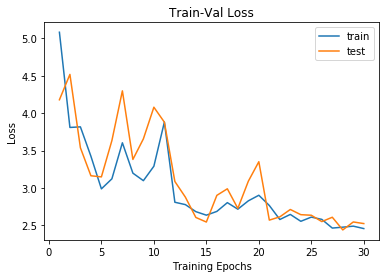

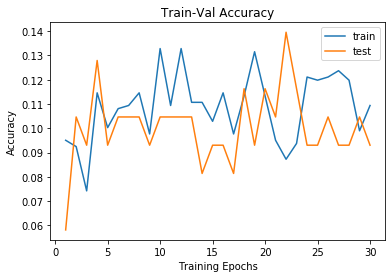

In [616]:
trainutils.plot_loss(loss_hist, metric_hist)